
# Ingesting syntethic data into a Polars dataframe
### <i>In Polars, we can ingest data using two primary approaches: using the read_csv function and the scan_csv function. Each approach has distinct characteristics and use cases.</i>
---------------------------



#### The read_csv function in Polars reads the entire CSV file into memory immediately, creating an eager DataFrame. This is similar to how Pandas handles data ingestion.

#### Characteristics:

- Eager Execution: The data is loaded and processed immediately.
- In-Memory DataFrame: The entire dataset is loaded into memory, making it suitable for smaller datasets that fit into the available RAM.
- Immediate Feedback: You can quickly inspect and manipulate the DataFrame right after loading.

#### The scan_csv function in Polars reads the CSV file in a lazy manner, creating a LazyFrame. This defers the actual reading and computation until an explicit action (like collect) is called.

#### Characteristics:

- Lazy Execution: The data loading and processing are deferred until explicitly requested.
- Optimized Query Planning: Polars optimizes the entire query plan before execution, which can result in performance improvements.
- Efficient Memory Usage: Suitable for larger datasets as it allows Polars to plan and optimize the data processing pipeline without loading the entire dataset into memory upfront.
- Composability: You can chain multiple transformations and only execute them once you call collect().

## Importing required modules

In [1]:
import pandas as pd
import polars as pl
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler


## Scaling up an existing CSV dataset (syntethic_flight_data.csv) to a larger size (new_data.csv) by replicating its contents. 

In [2]:
csv_file = "syntethic_flight_data.csv"
df = pd.read_csv(csv_file)

# Get the number of rows in the original file
original_row_count = df.shape[0]
target_row_count = 20000000

# Calculate how many times we need to replicate the data
replications = target_row_count // original_row_count
remainder = target_row_count % original_row_count

# Replicate the data
df_replicated = pd.concat([df] * replications + [df.iloc[:remainder]], ignore_index=True)

# Verify the new size of the DataFrame
print(f"Original number of rows: {original_row_count}")
print(f"Replicated number of rows: {df_replicated.shape[0]}")

# Write the new DataFrame to a new CSV file
new_csv_file = "new_data.csv"
df_replicated.to_csv(new_csv_file, index=False)

print(f"New CSV file with {target_row_count} rows created at: {new_csv_file}")


Original number of rows: 1032
Replicated number of rows: 20000000
New CSV file with 20000000 rows created at: new_data.csv


## The following script illustrates the different approaches to handling data filtering in Polars, emphasizing the trade-offs between eager and lazy evaluation in data processing.









In [3]:

file_path = 'new_data.csv'

# Filter
filter_date = "2023-10-26"

# Function to time the filtering using read_csv
def filter_using_read_csv(file_path, filter_date):
    start_time = time.time()
    # eager dataframe
    df = pl.read_csv(file_path)
    # Filter the DataFrame
    filtered_df = df.filter(pl.col('date') == filter_date)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return filtered_df, elapsed_time

# Function to time the filtering using scan_csv
def filter_using_scan_csv(file_path, filter_date):
    start_time = time.time()
    # LazyFrame
    lf = pl.scan_csv(file_path)
    # Filter the LazyFrame
    filtered_lf = lf.filter(pl.col('date') == filter_date)
    # Collect the results into an eager DataFrame
    filtered_df = filtered_lf.collect()
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return filtered_df, elapsed_time

# Perform filtering and timing with read_csv
filtered_df_read_csv, read_csv_time = filter_using_read_csv(file_path, filter_date)
print(f"Time taken to filter using read_csv: {read_csv_time} seconds")


# Perform filtering and timing with scan_csv
filtered_df_scan_csv, scan_csv_time = filter_using_scan_csv(file_path, filter_date)
print(f"Time taken to filter using scan_csv: {scan_csv_time} seconds")



Time taken to filter using read_csv: 6.748241901397705 seconds
Time taken to filter using scan_csv: 2.5091989040374756 seconds


### The results confirm the advantage of using scan_csv over read_csv for filtering in Polars, especially when dealing with larger datasets.

### But what about Polars vs Pandas? Aren't they just another type of bear?


In [4]:
csv_file_path = 'new_data.csv'

# Timing the loading of the CSV file into a Pandas DataFrame
start_time = time.time()
df_pandas = pd.read_csv(csv_file_path)
pandas_duration = time.time() - start_time

print(f"Time taken to load CSV using Pandas: {pandas_duration} seconds")

# Timing the loading of the CSV file into a Polars DataFrame using read_csv
start_time = time.time()
df_polars = pl.read_csv(csv_file_path)
polars_read_duration = time.time() - start_time

print(f"Time taken to load CSV using Polars read_csv: {polars_read_duration} seconds")

# Timing the loading of the CSV file into a Polars DataFrame using scan_csv (lazy mode)
start_time = time.time()
df_polars_lazy = pl.scan_csv(csv_file_path).collect()
polars_scan_duration = time.time() - start_time

print(f"Time taken to load CSV using Polars scan_csv (lazy mode): {polars_scan_duration} seconds")


Time taken to load CSV using Pandas: 21.560599088668823 seconds
Time taken to load CSV using Polars read_csv: 2.5893020629882812 seconds
Time taken to load CSV using Polars scan_csv (lazy mode): 8.681693077087402 seconds


#### The timings observed indicate that Polars' read_csv (eager mode) and scan_csv (lazy mode) are significantly faster tha pandas.This primarily stemms from its architecture and implementation choices:

1. Native Rust Implementation
Performance-Oriented Language: Polars is primarily implemented in Rust, a language known for its performance and memory safety. This allows Polars to leverage Rust's efficient memory management and low-level optimizations, resulting in faster execution compared to Python.
2. Lazy Evaluation
Efficient Query Planning: Polars employs lazy evaluation for data operations. This means that when you perform operations on a Polars DataFrame (e.g., filtering, aggregating), it builds a computation plan first without immediately executing it. This allows Polars to optimize the entire operation plan before executing, which can lead to more efficient query execution compared to Pandas.
3. SIMD Vectorization
SIMD (Single Instruction, Multiple Data): Polars uses SIMD vectorization techniques extensively. SIMD allows processors to perform the same operation on multiple data points simultaneously, leading to significant speedups for operations like arithmetic computations and aggregations.
4. Data Structure Optimization
Arrow Format: Polars uses Apache Arrow format for storing data internally. Arrow is designed for efficient data interchange between systems and languages. It stores data in a columnar format, which improves memory locality and cache efficiency, especially for analytics and data processing tasks.
5. Parallelization
Multi-Threading: Polars supports multi-threading for certain operations, allowing it to take advantage of modern multi-core processors. This parallelization can significantly speed up data processing tasks by distributing work across multiple threads.
6. Memory Efficiency
Reduced Overhead: Polars aims for reduced memory overhead compared to Pandas. Its memory management strategies and data structures are optimized for efficient memory usage, which can lead to faster execution times, especially for large datasets that exceed available RAM.
7. Targeted Use Cases
Data Engineering and Analysis: Polars is specifically designed for data engineering and analysis tasks, where speed and scalability are critical. It prioritizes performance optimizations that cater to these use cases, making it a suitable choice for handling large-scale datasets efficiently.




## Exploratory Data Analysis (EDA)

In [5]:
df = pl.read_csv('new_data.csv')

#### The head function shows by default the first 5 rows of a DataFrame. We can specify the number of rows we want to see (e.g. df.head(10)).

In [6]:
df.head()

aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
str,str,str,i64,f64,f64,i64,i64,f64
"""6c7c86ede5f20a4c5cd97a56f79dd3…","""2023-10-26""","""21:04:33.231000""",35000,38.61955,-90.12807,510,131,19.271622
"""56a7584bd0fd2151076be804881330…","""2023-10-21""","""21:02:42.143000""",40000,38.84384,-90.11713,487,202,36.495388
"""7920794164eb77440b937e73484836…","""2023-10-22""","""02:21:15.327000""",37975,38.55801,-89.70074,415,206,19.393315
"""5d9bd15d50428b6445669dbd2b3fe6…","""2023-10-21""","""20:58:38.905000""",37950,38.66107,-90.23029,432,214,29.25538
"""9825b10d1446628b83d4a4c415c24d…","""2023-10-22""","""14:04:58.095000""",36025,38.72662,-89.9468,435,210,19.473439


#### To inspect the data types of the columns in a DataFrame, we can use the dtypes attribute. This provides a list of data types corresponding to each column in the DataFrame.

In [7]:
df.dtypes


[String, String, String, Int64, Float64, Float64, Int64, Int64, Float64]

#### null_count returns the number of rows with null values in the column.

In [8]:
df.null_count()

aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


#### To get an impression of the data of a DataFrame, we can also use sample. With sample we get an <i>n</i> number of random rows from the DataFrame.

In [9]:
df.sample(2)

aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
str,str,str,i64,f64,f64,i64,i64,f64
"""cd2c5c574cbdf9745fed5e1f316d77…","""2023-10-22""","""00:24:33.087000""",7900,38.47556,-90.16687,155,115,22.822175
"""d62fb0ff1555418734a6dcd6cfdf80…","""2023-10-24""","""21:46:36.109000""",35050,38.62165,-90.1214,536,64,18.832467



#### Describe returns summary statistics of the DataFrame. It will provide several quick statistics if possible. In this scenario, we are looking at just three features (speed, altitude, Distance_From_Receiver)

In [10]:
selected_features =df.select(['speed','altitude','Distance_From_Receiver'])
description = selected_features.describe()
description

statistic,speed,altitude,Distance_From_Receiver
str,f64,f64,f64
"""count""",2e7,2e7,2e7
"""null_count""",0.0,0.0,0.0
"""mean""",403.652263,27857.490334,24.77302
"""std""",113.713833,12454.841485,13.823889
"""min""",53.0,950.0,1.079852
"""25%""",355.0,16700.0,14.216306
"""50%""",408.0,34000.0,22.494948
"""75%""",503.0,37000.0,32.356574
"""max""",597.0,47000.0,72.902156


#### Identify the numuber of unique values for a column

In [11]:
unique_id_values_count = df.select(pl.col('aircraft_icao_id').unique()).count()
#(unique_speed_values/df.shape[0])*100
unique_id_values_count

aircraft_icao_id
u32
943


#### Checking for infinite values. In the context of data analysis, infinite values refer to values that are either infinitely large (+∞) or infinitely small (-∞). These can occur in datasets due to various reasons, such as:

- Division by Zero: When a number is divided by zero, it results in an infinite value +∞.
- Logarithmic Calculations: Taking the logarithm of zero or a negative number can result in -∞.
- Overflow: When calculations exceed the largest representable number in the data type.
#### Infinite values can cause unexpected behavior in data analysis and machine learning models. For example, calculations involving division by infinity might lead to errors or nonsensical results.
- Unexpected behavior: Infinite values can cause unexpected behavior in data analysis and machine learning models. For example, calculations involving division by infinity might lead to errors or nonsensical results.
- Data quality issues: The presence of infinite values can indicate potential issues with data collection, processing, or calculations. It's important to investigate the source of these values to ensure data quality.
- Model instability: Machine learning models can be particularly sensitive to infinite values. They might not converge during training or produce unreliable predictions if fed data containing infinities.

In [12]:
# Check if 'speed' column has any infinite values
has_infinite = df.select(pl.col('speed').is_infinite()).to_series().any()

print(f"Does the 'speed' column have infinite values? {has_infinite}")

# Get rows where 'speed' column has infinite values
infinite_rows = df.filter(pl.col('speed').is_infinite())

if not infinite_rows.is_empty():
    print("\nRows with infinite values in 'speed' column:")
    print(infinite_rows)
else:
    print('There are no rows with infinite values to be returned')

Does the 'speed' column have infinite values? False
There are no rows with infinite values to be returned


#### We can use aggregation to sort the result and quickly identify specific speed values that are most or least common in the dataset (top 10 and bottom 10, along with their counts

In [13]:
top_10_speed = (
    df.group_by("speed")
    .agg(pl.col("speed").count().alias("count"))
    .sort("count", descending=True)
    .limit(10)
)

bottom_10_speed = (
    df.group_by("speed")
    .agg(pl.col("speed").count().alias("count"))
    .sort("count", descending=False)
    .limit(10)
)
# grouped_df.select(pl.col("count").unique())

print("Top 10 Speed", top_10_speed, "\n", "Bottom 10 Speed", bottom_10_speed)

Top 10 Speed shape: (10, 2)
┌───────┬────────┐
│ speed ┆ count  │
│ ---   ┆ ---    │
│ i64   ┆ u32    │
╞═══════╪════════╡
│ 529   ┆ 193799 │
│ 400   ┆ 193798 │
│ 398   ┆ 174419 │
│ 409   ┆ 174418 │
│ 407   ┆ 174418 │
│ 558   ┆ 155040 │
│ 404   ┆ 155040 │
│ 423   ┆ 155039 │
│ 549   ┆ 155039 │
│ 511   ┆ 155039 │
└───────┴────────┘ 
 Bottom 10 Speed shape: (10, 2)
┌───────┬───────┐
│ speed ┆ count │
│ ---   ┆ ---   │
│ i64   ┆ u32   │
╞═══════╪═══════╡
│ 143   ┆ 19379 │
│ 182   ┆ 19379 │
│ 191   ┆ 19379 │
│ 474   ┆ 19379 │
│ 483   ┆ 19379 │
│ 465   ┆ 19379 │
│ 242   ┆ 19379 │
│ 245   ┆ 19379 │
│ 516   ┆ 19379 │
│ 454   ┆ 19379 │
└───────┴───────┘


#### Using a histogram for understanding the overall distribution and frequency of speeds across the entire dataset, which can help in identifying patterns and outliers.

/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


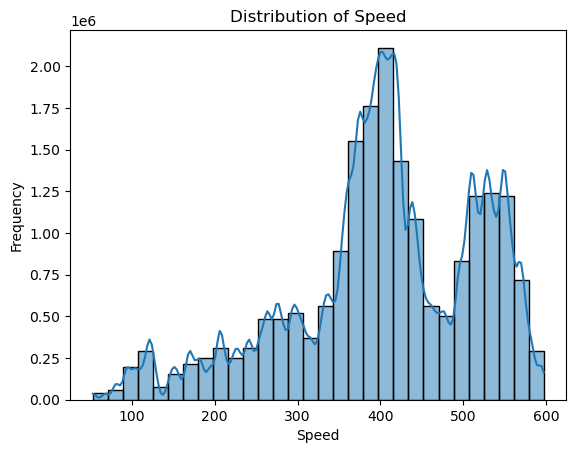

In [14]:
speed_series = df.select(pl.col('speed'))
sns.histplot(speed_series['speed'], bins=30, kde=True)
plt.title('Distribution of Speed')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.show()

#### We can also display the distribution of data with a boxplot (or box-and-whisker plot) based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. It also identifies potential outliers.

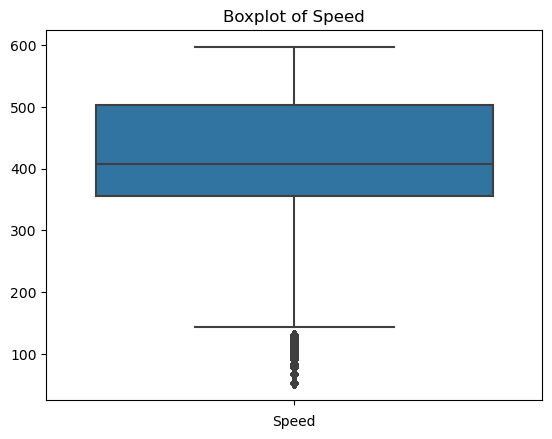

In [15]:
speed_df = df.select(pl.col('speed')).to_numpy()
sns.boxplot(y=speed_df)
plt.title('Boxplot of Speed')
plt.xlabel('Speed')
plt.show()

#### We can leverage the IQR (Inter Quartile Range) approach to identify possible outliers.

In [16]:

q1 = df.select(pl.col('speed').quantile(0.25)).to_numpy()[0][0]
q3 = df.select(pl.col('speed').quantile(0.75)).to_numpy()[0][0]

# Compute IQR
iqr = q3 - q1

# Define outlier boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df.filter((pl.col('speed') < lower_bound) | (pl.col('speed') > upper_bound))

print("Outliers:")
#print(outliers.shape[0]/df.shape[0])
set(outliers['speed'])

Outliers:


{53,
 68,
 79,
 81,
 84,
 92,
 94,
 95,
 96,
 98,
 103,
 104,
 110,
 113,
 117,
 119,
 121,
 122,
 123,
 124,
 125,
 127,
 129,
 130}

#### We can calculate the correlation between columns using the .corr method. This method can be used to find the Pearson correlation coefficient between two columns. The Pearson correlation coefficient measures the linear correlation between two variables, ranging from -1 to 1.


In [17]:
column1 = "speed"  
column2 = "altitude"  
# Calculate the Pearson correlation coefficient
correlation = df.select(pl.corr("altitude", "speed"))

# Optional: Specify correlation method (default is Pearson) and handle missing values
# correlation = df.select(pl.corr("altitude", "speed",method="spearman",propagate_nans=False))
print(f"Correlation between '{column1}' and '{column2}': {correlation}")


Correlation between 'speed' and 'altitude': shape: (1, 1)
┌──────────┐
│ altitude │
│ ---      │
│ f64      │
╞══════════╡
│ 0.773222 │
└──────────┘


#### We can visualize this positive correlation with a scatter plot.

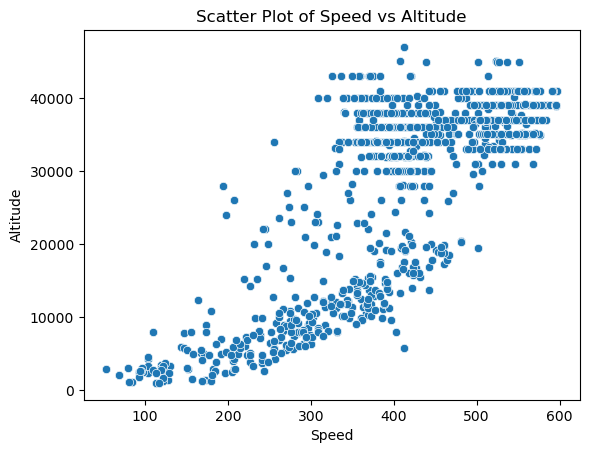

In [18]:
speed = df.select(pl.col(column1)).to_numpy().flatten()
altitude = df.select(pl.col(column2)).to_numpy().flatten()


sns.scatterplot(x=speed, y=altitude)
plt.title('Scatter Plot of Speed vs Altitude')
plt.xlabel('Speed')
plt.ylabel('Altitude')
plt.show()

### Data Transformations 

In [19]:
# Transform the string to a date
df = df.with_columns([
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date"),
    pl.col("timestamp").str.strptime(pl.Time, "%H:%M:%S%.f").alias("timestamp")
])
df.dtypes

[String, Date, Time, Int64, Float64, Float64, Int64, Int64, Float64]

In [20]:
df.head()

aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
str,date,time,i64,f64,f64,i64,i64,f64
"""6c7c86ede5f20a4c5cd97a56f79dd3…",2023-10-26,21:04:33.231,35000,38.61955,-90.12807,510,131,19.271622
"""56a7584bd0fd2151076be804881330…",2023-10-21,21:02:42.143,40000,38.84384,-90.11713,487,202,36.495388
"""7920794164eb77440b937e73484836…",2023-10-22,02:21:15.327,37975,38.55801,-89.70074,415,206,19.393315
"""5d9bd15d50428b6445669dbd2b3fe6…",2023-10-21,20:58:38.905,37950,38.66107,-90.23029,432,214,29.25538
"""9825b10d1446628b83d4a4c415c24d…",2023-10-22,14:04:58.095,36025,38.72662,-89.9468,435,210,19.473439


#### Additional functions can be found in the documentation at https://docs.pola.rs/api/python/stable/reference/expressions/functions.html

### The SQLContext in Polars offers a SQL interface for querying DataFrame data. This functionality is accessible via the SQLContext object, as well as through the sql() methods available on both DataFrame and LazyFrame objects, which internally utilize SQLContext.








In [21]:
ctx = pl.SQLContext()

ctx.register("my_table", df)

result = ctx.execute(
    """
    WITH aircrafts AS (
        SELECT * FROM my_table 
        WHERE date = '2023-10-22'
    )
    SELECT * FROM aircrafts
""",
    eager=True,
)

print(result)

shape: (2_771_323, 9)
┌─────────────┬────────────┬─────────────┬──────────┬───┬───────────┬───────┬─────────┬────────────┐
│ aircraft_ic ┆ date       ┆ timestamp   ┆ altitude ┆ … ┆ longitude ┆ speed ┆ heading ┆ Distance_F │
│ ao_id       ┆ ---        ┆ ---         ┆ ---      ┆   ┆ ---       ┆ ---   ┆ ---     ┆ rom_Receiv │
│ ---         ┆ date       ┆ time        ┆ i64      ┆   ┆ f64       ┆ i64   ┆ i64     ┆ er         │
│ str         ┆            ┆             ┆          ┆   ┆           ┆       ┆         ┆ ---        │
│             ┆            ┆             ┆          ┆   ┆           ┆       ┆         ┆ f64        │
╞═════════════╪════════════╪═════════════╪══════════╪═══╪═══════════╪═══════╪═════════╪════════════╡
│ 7920794164e ┆ 2023-10-22 ┆ 02:21:15.32 ┆ 37975    ┆ … ┆ -89.70074 ┆ 415   ┆ 206     ┆ 19.393315  │
│ b77440b937e ┆            ┆ 7           ┆          ┆   ┆           ┆       ┆         ┆            │
│ 73484836…   ┆            ┆             ┆          ┆   ┆           ┆

### More information can be found at https://docs.pola.rs/api/python/stable/reference/sql/index.html